In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold
from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split

from scipy.optimize import minimize, fmin

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
df_external = pd.read_csv('external/external.csv')
df_external.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [7]:
highest_ratio = df['Target'].value_counts()[df['Target'].value_counts()>1000].index.tolist()

In [8]:
highest_ratio

['0', '25 0', '23', '25', '7', '4', '21']

In [9]:
df_external = df_external[~df_external['Target'].isin(highest_ratio)]

In [10]:
len(df), len(df_external)

(31072, 36291)

In [11]:
train_df_orig = df.copy()    

lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]

for i in lows:
    target = str(i)
    indicies = train_df_orig.loc[train_df_orig['Target'] == target].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.startswith(target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.endswith(" "+target)].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.contains(" "+target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)

In [12]:
df_complete = df.append(df_external).reset_index(drop=True)

In [13]:
#df_complete = df_full.sample(frac=0.5).reset_index(drop=True, inplace=True)

In [14]:
len(df), len(df_external), len(df_complete)

(33409, 36291, 69700)

### get better validation split since the classes are very unevenly represented

In [15]:
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [16]:
def plot_ratio(targets):
    labels_num = [value.split() for value in targets]
    labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
    labels = ["" for _ in range(len(labels_num_flat))]
    for i in range(len(labels_num_flat)):
        labels[i] = subcell_locs[labels_num_flat[i]]

    fig, ax = plt.subplots(figsize=(15, 5))
    pd.Series(labels).value_counts().plot('bar', fontsize=14)

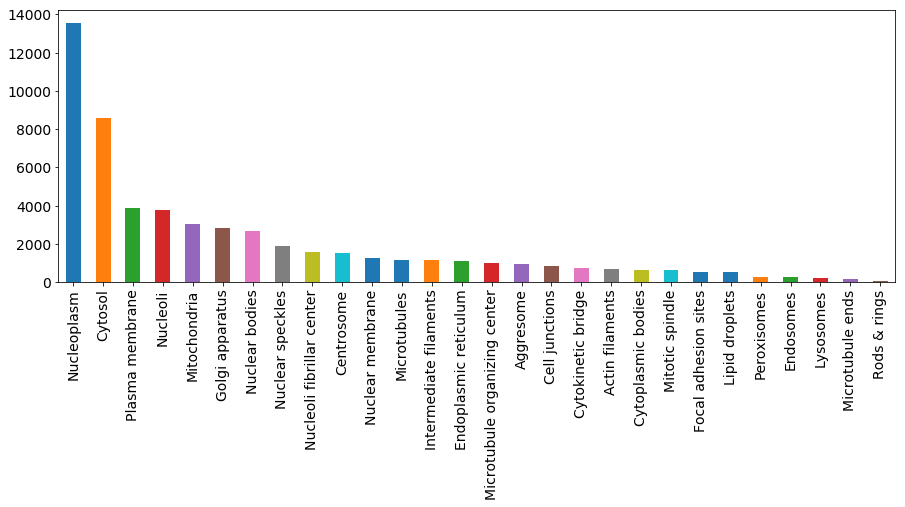

In [17]:
plot_ratio(df['Target'])

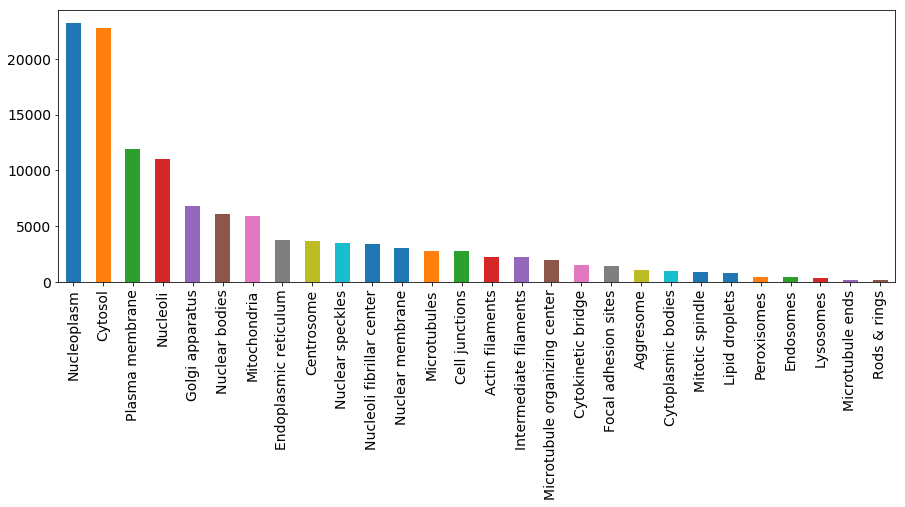

In [18]:
plot_ratio(df_complete['Target'])

### set everything we need for creating a ImageMultiDataset

In [19]:
fns = pd.Series([id + '.png' for id in df_complete.Id])
labels = [targ.split(' ') for targ in df_complete.Target]
classes=[str(i) for i in range(28)]

In [20]:
#without majority classes

#stats_train = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

#with test set
#stats_train_external = ([0.0574, 0.0478, 0.0311, 0.0848], [0.0899, 0.0748, 0.0793, 0.1265]) 

stats_train_external = ([0.0571, 0.0483, 0.0294, 0.0892],[0.0875, 0.0739, 0.0745, 0.1314])

In [21]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

test_ds,_ = ImageMulti4Channel.from_folder(path, 'test', pd.Series(test_ids),[['0'] \
                                           for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.,
                            max_lighting=0.2, max_warp=0.)

In [22]:
def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

In [23]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)
                 
                 
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": 
             if epoch >= 14: 
                 learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [24]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [25]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

In [26]:
#f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [27]:
def f1(preds, targs, th=0.4):
    return torch.tensor(f1_score((preds>th), targs, average='macro'))

In [28]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2): #gamma=4 working pretty bad
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [30]:
def f1_thresh_negative(thresh):
    return -f1_score((act_preds_tta.numpy()>thresh), y.numpy(), average='macro')

def f1_thresh(thresh):
    return f1_score((act_preds_tta.numpy()>thresh), y.numpy(), average='macro')

## continued training loop (all in one needed because of folding)

In [31]:
class Fold:
    def __init__(self, trn_id, val_id):
        self.train_index = trn_id
        self.val_index = val_id

In [ ]:
thresh = np.zeros((5, 28))
preds = torch.zeros(5, len(test_ids), 28)

scores = np.zeros(5)

for ind in range(5):
    
    fold = np.load(path/('fold_'+ str(ind) + '.npy'))
    
    train_index = fold.tolist().train_index
    val_index = fold.tolist().val_index
    
    print('Fold: ' + str(ind))
    print("Train:", len(train_index), "Valid:", len(val_index))
    
    trn_mask=[]

    for i in range(len(df_complete)):
        trn_mask.append(False if i in val_index else True)
    
    print('%d, %d, %d' % (trn_mask.count(True), trn_mask.count(False), len(trn_mask)))
    
    trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)

    torch.backends.cudnn.benchmark = True
    src_size = 512
    
    bs = 10
    data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(stats_train_external)
    learn = create_cnn(
        data,
        resnet50,
        ps=0.5,
        cut=-2,
        split_on=_resnet_split, 
        path=path,    
        metrics=[f1,acc],
        callback_fns=[ShowGraph] #, BnFreeze
    )
    
    learn.loss_func = FocalLoss()
    learn.clip = 1.0
    learn.split(split_on=_resnet_split)
    learn.load('finished_fold'+str(ind)+'_continued')
    learn.unfreeze()
    gc.collect()
    
    learn.callback_fns.append(partial(SaveModel, every='epoch', \
                                      monitor='val_loss',name='bestmodel_fullsz_'+str(ind)+'_continued'))
    lr = 2e-5
    lrs = slice(lr/2, lr)    
    learn.fit_one_cycle(10, lrs, div_factor=5) #24
    
    #lr = 1e-5
    #lrs = slice(lr/2, lr) 
    #learn.fit_one_cycle(4, lrs, div_factor=5) #24
    
    learn.save('finished_fold'+str(ind)+'_continued2')
    
    learn.model.eval()
    
    preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)
    
    act_preds_tta = torch.sigmoid(preds_tta)
    
    th = minimize(f1_thresh_negative, weights, method='Powell', options={'disp': True}).x

    scores[ind] = f1_thresh(th)
    
    preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

    act_preds_t_tta = torch.sigmoid(preds_t_tta)
    
    thresh[ind] = th
    preds[ind] = act_preds_t_tta
    
    del preds_tta, y, act_preds_tta
    gc.collect()

## predicting already trained folds 

In [32]:
thresh = np.zeros((5, 28))
preds = torch.zeros((5, len(test_ids), 28))

scores = np.zeros(5)

for ind in range(5):
    
    fold = np.load(path/('fold_'+ str(ind) + '.npy'))
    
    train_index = fold.tolist().train_index
    val_index = fold.tolist().val_index
    
    print('Fold: ' + str(ind))
    print("Train:", len(train_index), "Valid:", len(val_index))
    
    trn_mask=[]

    for i in range(len(df_complete)):
        trn_mask.append(False if i in val_index else True)
    
    print('%d, %d, %d' % (trn_mask.count(True), trn_mask.count(False), len(trn_mask)))
    
    trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)

    torch.backends.cudnn.benchmark = True
    src_size = 512
    
    bs = 12
    data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(stats_train_external)
    learn = create_cnn(
        data,
        resnet50,
        ps=[0.5, 0.5],
        cut=-2,
        split_on=_resnet_split, 
        path=path,    
        metrics=[f1,acc],
        callback_fns=[ShowGraph] #, BnFreeze
    )
    
    learn.loss_func = FocalLoss()
    learn.clip = 1.0
    learn.split(split_on=_resnet_split)
    learn.load('folding/finished_fold'+str(ind)+'_continued')
    learn.unfreeze()
    gc.collect()
    
    learn.model.eval()
    
    preds_v,y = learn.TTA(ds_type=DatasetType.Valid)
    preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)
    
    act_preds = torch.sigmoid(preds_v)
    act_preds_tta = torch.sigmoid(preds_tta)
    
    ensamble = act_preds * 0.1 + act_preds_tta * 0.9
    
    act_preds_np = ensamble.numpy()
    
    y_np = y.numpy()
    #th = minimize(f1_thresh_negative, weights, method='Powell', options={'disp': True}).x

    thresholds = np.linspace(0, 1, 1000)
    score = 0.0
    test_threshold=0.5*np.ones(28)
    best_threshold=np.zeros(28)
    best_val = np.zeros(28)
    for i in range(28):
        for threshold in thresholds:
            test_threshold[i] = threshold
            max_val = np.max(act_preds_np)
            val_predict = (act_preds_np > test_threshold)
            score = f1_score(y_np > 0.5, val_predict, average='macro')
            if score > best_val[i]:
                best_threshold[i] = threshold
                best_val[i] = score
        print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
        test_threshold[i] = best_threshold[i]
    print("Best threshold: ")
    print(best_threshold)
    print("Best f1:")
    print(best_val)
    
    scores[ind] = f1_thresh(best_threshold)
    
    preds_t,y_t = learn.get_preds(DatasetType.Test)
    preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)
    
    act_preds_t = torch.sigmoid(preds_t)
    act_preds_t_tta = torch.sigmoid(preds_t_tta)
    
    ensamble_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9
    
    thresh[ind] = best_threshold
    preds[ind] = ensamble_t
    
    del preds_tta, y, act_preds_tta
    gc.collect()

Total time: 20:39



In [33]:
scores

array([0.830579, 0.835868, 0.82859 , 0.839785, 0.840261])

In [34]:
thresh.shape, preds.shape

((5, 28), torch.Size([5, 11702, 28]))

In [35]:
thresh_mean = thresh.mean(axis=0)

In [36]:
#thresh_min = thresh.min(axis=0)

In [37]:
preds_mean = preds.mean(dim=0)

In [38]:
thresh

array([[0.413413, 0.424424, 0.403403, 0.39039 , ..., 0.37037 , 0.422422, 0.316316, 0.282282],
       [0.418418, 0.444444, 0.415415, 0.393393, ..., 0.482482, 0.432432, 0.441441, 0.165165],
       [0.414414, 0.413413, 0.433433, 0.331331, ..., 0.376376, 0.409409, 0.412412, 0.22022 ],
       [0.416416, 0.357357, 0.428428, 0.357357, ..., 0.373373, 0.454454, 0.366366, 0.299299],
       [0.399399, 0.438438, 0.431431, 0.356356, ..., 0.325325, 0.443443, 0.433433, 0.216216]])

In [39]:
thresh_mean

array([0.412412, 0.415616, 0.422422, 0.365766, 0.484484, 0.415215, 0.37017 , 0.453453, 0.396797, 0.374174, 0.663063,
       0.376577, 0.373574, 0.405806, 0.364765, 0.32012 , 0.36997 , 0.343343, 0.437437, 0.351952, 0.443844, 0.403203,
       0.415616, 0.405806, 0.385586, 0.432432, 0.393994, 0.236637])

In [84]:
thresh_fixed = (weights*0.92).numpy()

In [85]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>thresh_fixed)[0]])) \
               for row in np.array(preds_mean)]

### replace empty predicitons with highest probability

In [89]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [90]:
len(indices)

0

In [88]:
step = 0.05
loop = 1
indices = [i for i, x in enumerate(pred_labels) if x == '']

while len(indices) > 0:
    for ind in indices: 
        pred_labels[ind] = \
        ' '.join(list([str(i) for i in np.nonzero(preds_mean[ind].numpy()>thresh_mean*1-(step*loop))[0]]))
    indices = [i for i, x in enumerate(pred_labels) if x == '']
    print(loop)
    loop+=1

1
2
3
4


In [74]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [ ]:
for ind in indices:
    act_preds_t_tta[ind]
    _max = torch.max(act_preds_t_tta[ind])
    argmax = ((act_preds_t_tta[ind] == _max).nonzero())
    pred_labels[ind] = str(argmax.numpy()[0][0])

### create submission and replace the leaked prediction for leaderboard comparison

In [91]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [92]:
len(sub['Predicted'][sub['Predicted']==''])

0

In [93]:
test_matches = pd.read_csv(path/'test_matches.csv')

In [94]:
test_matches.head()

,Extra,Test,SimR,SimG,SimB,Target,Target_noisey
0,ENSG00000001497_44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,10,6,2,25 18 0,NaN
1,ENSG00000006194_35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,25 17 0,NaN
2,ENSG00000008324_47377_688_E7_10,b029f372-bad9-11e8-b2b9-ac1f6b6435d0,2,0,2,23 2,NaN
3,ENSG00000019186_63771_1414_D12_2,adc182fa-bad2-11e8-b2b8-ac1f6b6435d0,6,2,0,23 0 21,NaN
4,ENSG00000025770_67932_1255_A3_4,39508fe6-bad3-11e8-b2b8-ac1f6b6435d0,0,0,0,16 0,NaN


In [95]:
for _, row in test_matches.iterrows():
    print(sub[sub.Id == row.Test].Predicted)
    sub['Predicted'][sub.Id == row.Test] = row.Target
    print(sub[sub.Id == row.Test].Predicted)

5419    0 18 25
Name: Predicted, dtype: object
5419    25 18 0
Name: Predicted, dtype: object
3901    17 25
Name: Predicted, dtype: object
3901    25 17 0
Name: Predicted, dtype: object
8073    23 25
Name: Predicted, dtype: object
8073    23 2
Name: Predicted, dtype: object
7947    0 21 25
Name: Predicted, dtype: object
7947    23 0 21
Name: Predicted, dtype: object
2571    0 16
Name: Predicted, dtype: object
2571    16 0
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
2214    0 14 16 25
Name: Predicted, dtype: object
2214    14 0
Name: Predicted, dtype: object
1838    14
Name: Predicted, dtype: object
1838    14
Name: Predicted, dtype: object
9721    14 16
Name: Predicted, dtype: object
9721    14
Name: Predicted, dtype: object
6119    0 16
Name: Predicted, dtype: object
6119    0
Name: Predicted, dtype: object
783    0 16 21
Name: Predicted, dtype: object
783    21
Name: Predicted, dtype: object
9781    7
Name: Pr

7303    14
Name: Predicted, dtype: object
7198    12 21
Name: Predicted, dtype: object
7198    12 2
Name: Predicted, dtype: object
8754    4
Name: Predicted, dtype: object
8754    4 21
Name: Predicted, dtype: object
5466    0 2
Name: Predicted, dtype: object
5466    0
Name: Predicted, dtype: object
9881    0 12
Name: Predicted, dtype: object
9881    12
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
10215    4 25
Name: Predicted, dtype: object
10215    18 17
Name: Predicted, dtype: object
4345    0 23
Name: Predicted, dtype: object
4345    23
Name: Predicted, dtype: object
6479    0 16 25
Name: Predicted, dtype: object
6479    0
Name: Predicted, dtype: object
1108    1
Name: Predicted, dtype: object
1108    1 0
Name: Predicted, dtype: object
10394    0 13
Name: Predicted, dtype: object
10394    13
Name: Predicted, dtype: object
7993    0 13 25
Name: Predicted, dtype: object
7993    13
Name: Predicted, dtype: object
6806  

Name: Predicted, dtype: object
5966    25 18 14
Name: Predicted, dtype: object
488    4
Name: Predicted, dtype: object
488    23 4
Name: Predicted, dtype: object
9068    0 25
Name: Predicted, dtype: object
9068    25 0 21
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
406    0 20 23
Name: Predicted, dtype: object
406    25 20
Name: Predicted, dtype: object
11535    0 20 23
Name: Predicted, dtype: object
11535    25 20
Name: Predicted, dtype: object
8265    0 16
Name: Predicted, dtype: object
8265    16 0
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
9047    0 2
Name: Predicted, dtype: object
9047    2 21
Name: Predicted, dtype: object
5299    7 25
Name: Predicted, dtype: object
5299    25 7
Name: Predicted, dtype: object
4162    0 5
Name: Predicted, dtype: object
4162    0
Name: Predicted, dtype: object
5013    5
Name: Predicted, dtype: object
5013   

## public lb f1 scores:

### using with_external/best/bestmodel_externalres50_4E 

### with leak

- 0.579 

### without leak

- 0.554 filling nulls

- 0.557 not filling nulls thresh * 0.845 (best val thresh)

- 0.555 not filling nulls thresh * 0.9

- 0.558 not filling nulls thresh * 0.8

In [96]:
sub.to_csv(path/'resnet50_5fold_continued_fixedthresh.csv', header=True, index=False)

In [97]:
pred_labels

['2',
 '5',
 '0 5 25',
 '0 25',
 '2 25',
 '4',
 '4 25',
 '0 25',
 '0',
 '4 21 25',
 '25',
 '5',
 '25',
 '7 20',
 '25',
 '18',
 '2',
 '0 5',
 '14',
 '5',
 '1 6 25',
 '2 5',
 '0 25',
 '0 21',
 '0 4',
 '25',
 '0',
 '0',
 '0 25',
 '0 5',
 '13 21',
 '0 18',
 '17 18 25',
 '5 25',
 '0 7',
 '13',
 '25',
 '3',
 '21',
 '1',
 '0 25',
 '6 25',
 '0 25',
 '19 25',
 '25',
 '6 20',
 '0',
 '0',
 '6 23',
 '0',
 '25',
 '5',
 '24',
 '25',
 '3',
 '0 25',
 '0 25',
 '11',
 '0 25',
 '25',
 '2 20',
 '0 5 21 25',
 '14 25',
 '21 25',
 '23',
 '0 25',
 '3 21 25',
 '0 25',
 '0 20',
 '25',
 '2',
 '0 2 25',
 '14',
 '4',
 '21',
 '0',
 '4',
 '0 1',
 '0 25',
 '0 25',
 '25',
 '0 25',
 '21',
 '21 25',
 '18',
 '0 25',
 '23',
 '0 21',
 '14 25',
 '14 25',
 '25',
 '11',
 '23',
 '12 13',
 '23',
 '0 25',
 '25',
 '0 7 25',
 '24',
 '0 23 25',
 '25',
 '23',
 '23',
 '0 4 23',
 '7',
 '21 22 25',
 '0 14 17',
 '0 11 24 25',
 '20',
 '0 1 25',
 '0 2',
 '1 25',
 '16 17 25',
 '0 22 25',
 '25',
 '23 25',
 '0',
 '4 25',
 '14 25',
 '26',
 '0